In [1]:
!nvidia-smi

Wed Apr 20 10:23:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
! pip install transformers pytorch-lightning --quiet
! sudo apt -qq install git-lfs
import math
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, UnidentifiedImageError
from pathlib import Path
import torch
import glob
import pytorch_lightning as pl
from huggingface_hub import HfApi, Repository
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchmetrics import Accuracy
from transformers import ViTFeatureExtractor, ViTForImageClassification
from pytorch_lightning.callbacks import ModelCheckpoint

     |████████████████████████████████| 4.0 MB 5.5 MB/s 
     |████████████████████████████████| 582 kB 17.9 MB/s 
     |████████████████████████████████| 596 kB 32.6 MB/s 
     |████████████████████████████████| 895 kB 36.3 MB/s 
     |████████████████████████████████| 77 kB 4.4 MB/s 
     |████████████████████████████████| 6.6 MB 34.2 MB/s 
     |████████████████████████████████| 136 kB 40.5 MB/s 
     |████████████████████████████████| 408 kB 36.2 MB/s 
     |████████████████████████████████| 1.1 MB 50.6 MB/s 
     |████████████████████████████████| 94 kB 3.3 MB/s 
     |████████████████████████████████| 144 kB 52.6 MB/s 
     |████████████████████████████████| 271 kB 53.0 MB/s 
The following NEW packages will be installed:
  git-lfs
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 2,129 kB of archives.
After this operation, 7,662 kB of additional disk space will be used.
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like progra

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras import callbacks
from numpy import asarray
from sklearn import metrics

import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os
import glob

import pandas as pd
import numpy as np
import tensorflow as tf
!pip install tensorflow-addons
import tensorflow_addons as tfa
import glob, warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

warnings.filterwarnings('ignore')
print('TensorFlow Version ' + tf.__version__)

     |████████████████████████████████| 1.1 MB 5.1 MB/s 
TensorFlow Version 2.8.0


In [4]:
!pip install datasets

     |████████████████████████████████| 325 kB 5.4 MB/s 
     |████████████████████████████████| 212 kB 51.6 MB/s 
     |████████████████████████████████| 127 kB 51.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [5]:
!git clone https://github.com/darshan154/data.git

Cloning into 'data'...
remote: Enumerating objects: 1972, done.
remote: Counting objects: 100% (1972/1972), done.
remote: Compressing objects: 100% (1970/1970), done.
remote: Total 1972 (delta 9), reused 1963 (delta 0), pack-reused 0
Receiving objects: 100% (1972/1972), 4.66 MiB | 15.19 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [6]:
import os
import datasets

def create_image_folder_dataset(root_path):
  """creates `Dataset` from image folder structure"""
  
  # get class names by folders names
  _CLASS_NAMES= os.listdir(root_path)
  # defines `datasets` features`
  features=datasets.Features({
                      "img": datasets.Image(),
                      "label": datasets.features.ClassLabel(names=_CLASS_NAMES),
                  })
  # temp list holding datapoints for creation
  img_data_files=[]
  label_data_files=[]
  # load images into list for creation
  for img_class in os.listdir(root_path):
    for img in os.listdir(os.path.join(root_path,img_class)):
      path_=os.path.join(root_path,img_class,img)
      img_data_files.append(path_)
      label_data_files.append(img_class)
  # create dataset
  ds = datasets.Dataset.from_dict({"img":img_data_files,"label":label_data_files},features=features)
  return ds

In [7]:
occupation_ds = create_image_folder_dataset("./data/occupation")

In [8]:
occupation_ds

Dataset({
    features: ['img', 'label'],
    num_rows: 2062
})

In [9]:
img_class_labels = occupation_ds.features["label"].names

In [10]:
model_id = "google/vit-base-patch16-224"

In [11]:
from transformers import ViTFeatureExtractor, BeitFeatureExtractor, BeitForImageClassification
from tensorflow import keras 
from tensorflow.keras import layers


feature_extractor = ViTFeatureExtractor.from_pretrained(model_id)

# learn more about data augmentation here: https://www.tensorflow.org/tutorials/images/data_augmentation
data_augmentation = keras.Sequential(
    [
        layers.Resizing(feature_extractor.size, feature_extractor.size),
        layers.Rescaling(1./255),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# use keras image data augementation processing
def augmentation(examples):
    # print(examples["img"])
    examples["pixel_values"] = [data_augmentation(image) for image in examples["img"]]
    return examples


# basic processing (only resizing)
def process(examples):
    examples.update(feature_extractor(examples['img'], ))
    return examples

# we are also renaming our label col to labels to use `.to_tf_dataset` later
occupation_ds = occupation_ds.rename_column("label", "labels")

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [12]:
processed_dataset = occupation_ds.map(process, batched=True)
processed_dataset

# # augmenting dataset takes a lot of time
# processed_dataset = occupation_ds.map(augmentation, batched=True)

  0%|          | 0/3 [00:00<?, ?ba/s]

Dataset({
    features: ['img', 'labels', 'pixel_values'],
    num_rows: 2062
})

In [13]:
# test size will be 15% of train dataset
test_size=.35

processed_dataset = processed_dataset.shuffle().train_test_split(test_size=test_size)

In [14]:
from huggingface_hub import HfFolder
import tensorflow as tf

id2label = {str(i): label for i, label in enumerate(img_class_labels)}
label2id = {v: k for k, v in id2label.items()}

num_train_epochs = 7
train_batch_size = 64
eval_batch_size = 64
learning_rate = 1e-4
weight_decay_rate=0.5
num_warmup_steps=0
output_dir=model_id.split("/")[1]
hub_token = HfFolder.get_token() # or your token directly "hf_xxx"
hub_model_id = f'{model_id.split("/")[1]}-occupationDs'
fp16=True

# Train in mixed-precision float16
# Comment this line out if you're using a GPU that will not benefit from this
if fp16:
  tf.keras.mixed_precision.set_global_policy("mixed_float16")

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla K80, compute capability 3.7
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [15]:
from transformers import DefaultDataCollator

# Data collator that will dynamically pad the inputs received, as well as the labels.
data_collator = DefaultDataCollator(return_tensors="tf")

# converting our train dataset to tf.data.Dataset
tf_train_dataset = processed_dataset["train"].to_tf_dataset(
   columns=['pixel_values'],
   label_cols=["labels"],
   shuffle=True,
   batch_size=train_batch_size,
   collate_fn=data_collator)

# converting our test dataset to tf.data.Dataset
tf_eval_dataset = processed_dataset["test"].to_tf_dataset(
   columns=['pixel_values'],
   label_cols=["labels"],
   shuffle=False,
   batch_size=eval_batch_size,
   collate_fn=data_collator)

In [16]:
from transformers import TFViTForImageClassification, create_optimizer
import tensorflow as tf

# create optimizer wight weigh decay
num_train_steps = len(tf_train_dataset) * num_train_epochs
optimizer, lr_schedule = create_optimizer(
    init_lr=learning_rate,
    num_train_steps=num_train_steps,
    weight_decay_rate=weight_decay_rate,
    num_warmup_steps=num_warmup_steps,
)

# load pre-trained ViT model
model = TFViTForImageClassification.from_pretrained(
    model_id,
    num_labels=len(img_class_labels),
    ignore_mismatched_sizes=True,
    id2label=id2label,
    label2id=label2id,
)

# define loss
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# define metrics 
metrics=[
    tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
    tf.keras.metrics.SparseTopKCategoricalAccuracy(3, name="top-3-accuracy"),
]

# # compile model
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics
              )

Downloading:   0%|          | 0.00/68.0k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFViTForImageClassification.

Some weights of TFViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier/kernel:0: found shape (768, 1000) in the checkpoint and (768, 5) in the model instantiated
- classifier/bias:0: found shape (1000,) in the checkpoint and (5,) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
# # alternatively create Image Classification model using Keras Layer and ViTModel 
# # here you can also add the processing layers of keras

# import tensorflow as tf
# from transformers import TFViTModel

# base_model = TFViTModel.from_pretrained('google/vit-base-patch16-224-in21k')


# # inputs
# pixel_values = tf.keras.layers.Input(shape=(3,224,224), name='pixel_values', dtype='float32')

# # model layer
# vit = base_model.vit(pixel_values)[0]
# classifier = tf.keras.layers.Dense(5, activation='softmax', name='outputs')(vit[:, 0, :])

# # model
# keras_model = tf.keras.Model(inputs=pixel_values, outputs=classifier)

In [18]:
import os
from transformers.keras_callbacks import PushToHubCallback
from tensorflow.keras.callbacks import TensorBoard as TensorboardCallback, EarlyStopping

callbacks=[]

callbacks.append(TensorboardCallback(log_dir=os.path.join(output_dir,"logs")))
callbacks.append(EarlyStopping(monitor="val_accuracy",patience=12))
if hub_token:
  callbacks.append(PushToHubCallback(output_dir=output_dir,
                                     hub_model_id=hub_model_id,
                                     hub_token=hub_token))

In [19]:
train_results = model.fit(
    tf_train_dataset,
    validation_data=tf_eval_dataset,
    callbacks=callbacks,
    epochs=num_train_epochs,
)

Epoch 1/7
20/20 [==============================] - 611s 29s/step - loss: 0.9487 - accuracy: 0.6398 - top-3-accuracy: 0.9117 - val_loss: 0.7031 - val_accuracy: 0.7161 - val_top-3-accuracy: 0.9778
Epoch 2/7
20/20 [==============================] - 575s 29s/step - loss: 0.4483 - accuracy: 0.8422 - top-3-accuracy: 0.9930 - val_loss: 0.5209 - val_accuracy: 0.7992 - val_top-3-accuracy: 0.9889
Epoch 3/7
20/20 [==============================] - 542s 27s/step - loss: 0.2658 - accuracy: 0.9133 - top-3-accuracy: 0.9992 - val_loss: 0.5210 - val_accuracy: 0.8172 - val_top-3-accuracy: 0.9861
Epoch 4/7
20/20 [==============================] - 575s 29s/step - loss: 0.1839 - accuracy: 0.9422 - top-3-accuracy: 1.0000 - val_loss: 0.5427 - val_accuracy: 0.8227 - val_top-3-accuracy: 0.9848
Epoch 5/7
20/20 [==============================] - 543s 27s/step - loss: 0.0885 - accuracy: 0.9797 - top-3-accuracy: 1.0000 - val_loss: 0.5579 - val_accuracy: 0.8158 - val_top-3-accuracy: 0.9903
Epoch 6/7
20/20 [========

In [20]:
ypred = model.predict(tf_eval_dataset)
ypred = ypred.logits.argmax(-1)

In [21]:
true_categories = tf.concat([y for x, y in tf_eval_dataset], axis=0)
true_categories = np.array(true_categories)

In [22]:
lbls = []
for i in range(len(id2label)):
    lbls.append(id2label[str(i)])
lbls

['teachers', 'doctor', 'player', 'police', 'news']

              precision    recall  f1-score   support

           0       0.81      0.73      0.77       168
           1       0.78      0.88      0.83       176
           2       0.96      0.96      0.96        96
           3       0.72      0.69      0.71       103
           4       0.92      0.92      0.92       179

    accuracy                           0.84       722
   macro avg       0.84      0.83      0.84       722
weighted avg       0.84      0.84      0.84       722



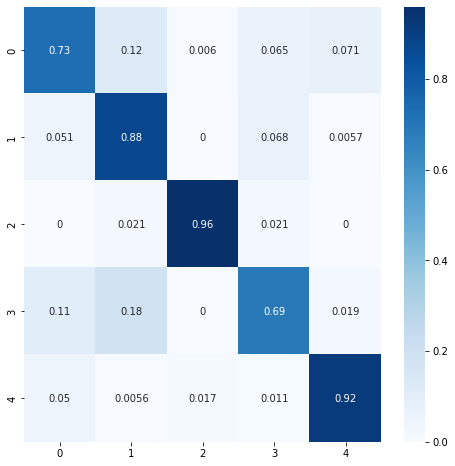

In [23]:
confusionmatrix = confusion_matrix(true_categories, ypred, normalize='true')
plt.figure(figsize = (8, 8))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)

print(classification_report(true_categories, ypred))

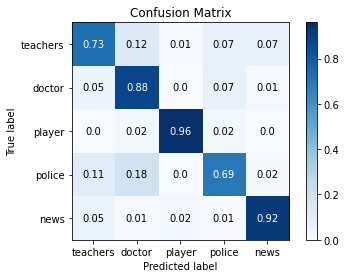

In [24]:
# ax= plt.subplot()
# confusionmatrix = confusion_matrix(true_categories, ypred, normalize='true', ax = ax)
# plt.figure(figsize = (8, 8))
# sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)
# ax.set_title('Confusion Matrix'); 
# ax.xaxis.set_ticklabels(lbls); ax.yaxis.set_ticklabels(lbls);
# print(classification_report(true_categories, ypred, target_names=lbls))

!pip install scikit-plot
import matplotlib.pyplot as plt
import scikitplot as skplt
ax = plt.subplot()
#Normalized confusion matrix for the K-NN model
skplt.metrics.plot_confusion_matrix(true_categories, ypred, normalize=True, ax = ax)
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(lbls); ax.yaxis.set_ticklabels(lbls);
plt.show()


In [25]:
ypred = ypred.reshape((ypred.shape[0], 1))
true_categories = true_categories.reshape((true_categories.shape[0], 1))

from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(true_categories, ypred))

Accuracy: 0.8365650969529086
